Importing required packages

In [1]:
import pandas as pd
import math
import datetime as dt
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Collecting all the quarterly data for analysis

In [2]:
df1 = pd.read_csv('q3_2016.csv')
df1['duration'] = df1['duration'].div(60) #Changing unit of trip duration to minutes for consistency
df2 = pd.read_csv('q4_2016.csv')
df2['duration'] = df2['duration'].div(60)
df3 = pd.read_csv('q1_2017.csv')
df3['duration'] = df3['duration'].div(60)
df4 = pd.read_csv('q2_2017.csv')
df4['duration'] = df4['duration'].div(60)
df5 = pd.read_csv('q3_2017.csv')
df6 = pd.read_csv('q4_2017.csv')
df7 = pd.read_csv('q1_2018.csv')
df8 = pd.read_csv('q2_2018.csv')

df = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8],sort=True)

In [3]:
#Filtering duration values by limiting it from 0 to 180
df = df[(df['duration']>=0) & (df['duration']<180)]

In [4]:
df.shape

(461582, 16)

In [5]:
#Creating 30 mins time block that walk-up users have to pay for
df['time_block_count'] = df['duration'].apply(lambda duration: math.ceil(duration/30))

#Creating another feature for 30 minute blocks for passholders that excludes first 30 mintues
df['time_block_count_post_free'] = df['duration'].apply(lambda duration: math.ceil(duration/30))-1

# Previous Pricing Model

In [6]:
old_agg_pass_groups = pd.DataFrame()
old_agg_pass_groups = df.groupby('passholder_type').agg({
    'trip_id' : 'count',
    #'Walk-up' : 'sum',
    'time_block_count' : 'sum',
    'time_block_count_post_free' : 'sum',
    'duration' : 'sum'
}).rename(columns = {
    'trip_id' : 'total_trips',
    #'Walk-up' : 'pay_count_walk_up',
    'time_block_count' : 'total_30min_blocks',
    'time_block_count_post_free' : 'total_30min_blocks_post_free',
    'duration' : 'total_minutes'
}).reset_index()
old_agg_pass_groups.index = old_agg_pass_groups['passholder_type']
old_agg_pass_groups = old_agg_pass_groups.drop('passholder_type',1)
old_agg_pass_groups

,total_trips,total_30min_blocks,total_30min_blocks_post_free,total_minutes
passholder_type,,,,
Flex Pass,22723,24349,1626,2.251768e+05
Monthly Pass,284049,296319,12270,2.523838e+06
One Day Pass,14836,28370,13534,6.299470e+05
Walk-up,139974,212148,72174,3.871049e+06


There is no unique identifier for passholders so the number of passes sold can’t be inferred from data itself. Total number of passes sold since January 2016 is 67,013 in 3 year period so it would be safe to expect roughly 20,000 passes sold during the year-long period for first two years and the remaining during the last year. The sales of each pass type would be estimated from a breakeven perspective i.e the average number of trips needed to cover the price of a pass. 

The breakeven analysis is conducted for trips under 30 minutes since the median trip duration is 12 minutes. Number of rides to break even is calculated by dividing the pass price by the difference in the price to ride without pass and the price to ride with pass. Then, the number of passes sold is estimated by dividing the total number of rides by the number of rides to break even. 


In [7]:
## PREVIOUS PRICING MODEL
# Rides to break even = Pass price / (Price to ride without pass - Price to ride with pass)
# Passes sold = Total rides / Rides to break even

price_wo_pass = 3.5
price_w_pass_day = 0
price_w_pass_month = 0
price_w_pass_annual = 1.75

# Average difference between passholders and walk-up riders across previous and current pricing.
# This is represented by the difference in prices per 30 minute block since pass holders get the first 30 minutes free.
# As current data is from before the price change, previous prices are used to estimate number of passes.

day_diff = price_wo_pass - price_w_pass_day
month_diff = price_wo_pass - price_w_pass_month
annual_diff = price_wo_pass - price_w_pass_annual

# Prices of passes.

day_pass_price = 7
month_pass_price = 20
annual_pass_price = 40

# Estimated rides required for breakeven.

rides_day_pass_estimate = day_pass_price / day_diff
rides_month_pass_estimate = month_pass_price / month_diff
rides_annual_pass_estimate = annual_pass_price / annual_diff

print(" Rides per day required for daily pass:",rides_day_pass_estimate,'\n', 
      "Rides per month required for monthly pass:", rides_month_pass_estimate,'\n', 
      "Rides per year required for annual pass:", rides_annual_pass_estimate)

 Rides per day required for daily pass: 2.0 
 Rides per month required for monthly pass: 5.714285714285714 
 Rides per year required for annual pass: 22.857142857142858


Rides per day required for daily pass: 2.0 
 Rides per month required for monthly pass: 5.714285714285714 
 Rides per year required for annual pass: 22.857142857142858
Looking at the number of rides required of breakeven and assessing the numbers, the numbers seem to be on the low side.

Daily pass holders are likely to perform more than a round trip if they were purchasing a day pass.

Monthly pass holders are likely to be the occasional commuters and even at a conservative 2 rides/week to work would tally 8 rides a month.

Annual pass holders are the hardest to gauge due to the low $40 price point of the flex point from the previous pricing plan. For now, they'll be scaled to the same factor as day and monthly pass numbers.

Scaling daily passes up to a conservative 3 rides is a 50% increase in rides while scaling monthly rides up to a conservative 8 rides is a 40% increase. For conservative estimates, we scale the three estimates by a common factor of 40%.

In [8]:
rides_day_pass_estimate *= 1.4
rides_month_pass_estimate *= 1.4
rides_annual_pass_estimate *= 1.4

print("Rides per day required for daily pass (scaled):",rides_day_pass_estimate,'\n', 
      "Rides per month required for monthly pass (scaled):", rides_month_pass_estimate,'\n', 
      "Rides per year required for annual pass (scaled):", rides_annual_pass_estimate)

Rides per day required for daily pass (scaled): 2.8 
 Rides per month required for monthly pass (scaled): 8.0 
 Rides per year required for annual pass (scaled): 32.0


In [9]:
# Divide total trips by rides required for breakeven per pass duration (day/month/year) to get estimated number
# of passholders.

passes_sold_day = math.ceil(old_agg_pass_groups.loc['One Day Pass','total_trips']/rides_day_pass_estimate)
passes_sold_month = math.ceil(old_agg_pass_groups.loc['Monthly Pass','total_trips']/rides_month_pass_estimate)
passes_sold_annual = math.ceil(old_agg_pass_groups.loc['Flex Pass','total_trips']/rides_annual_pass_estimate)
passes_sold_total = passes_sold_day + passes_sold_month + passes_sold_annual

old_agg_pass_groups['passes_sold'] = [passes_sold_annual, passes_sold_month, passes_sold_day, 0]

print("Estimated passes sold for daily pass:",passes_sold_day,'\n', 
      "Estimated passes sold for monthly pass:", passes_sold_month,'\n', 
      "Estimated passes sold for annual pass:", passes_sold_annual,'\n',
     "Total passes sold:", passes_sold_total)

Estimated passes sold for daily pass: 5299 
 Estimated passes sold for monthly pass: 35507 
 Estimated passes sold for annual pass: 711 
 Total passes sold: 41517


This is roughly inline with the previous estimate of 20,000 per year since 41,517 is the estimate for 2 year period. 

The objective function for this optimization model to maximum total revenue from pass sales and rides is formulated.

The total revenue can be split into the following:

Total revenue from walk up users = Price for 30 minutes of usage * Total 30 minute blocks by walk up users
Total revenue from day, month pass users = Price for 30 minutes of usage * Total 30 minute blocks after free first 30 minutes
Total revenue from selling passes = Prices of respective passes * Total passes sold in respective pass types
Now this objective function can be represented in PuLP.

In [10]:
old_agg_pass_groups['previous_pass_prices'] = [40, 20, 7, 0]
old_agg_pass_groups['new_pass_prices'] = [150,17, 5, 0]
old_agg_pass_groups['average_charged_blocks_per_ride'] = old_agg_pass_groups['total_30min_blocks_post_free'] / old_agg_pass_groups['total_trips']
old_agg_pass_groups['percent_total_trips'] = old_agg_pass_groups['total_trips']/sum(old_agg_pass_groups['total_trips'])
old_agg_pass_groups

,total_trips,total_30min_blocks,total_30min_blocks_post_free,total_minutes,passes_sold,previous_pass_prices,new_pass_prices,average_charged_blocks_per_ride,percent_total_trips
passholder_type,,,,,,,,,
Flex Pass,22723,24349,1626,2.251768e+05,711,40,150,0.071557,0.049229
Monthly Pass,284049,296319,12270,2.523838e+06,35507,20,17,0.043197,0.615381
One Day Pass,14836,28370,13534,6.299470e+05,5299,7,5,0.912240,0.032142
Walk-up,139974,212148,72174,3.871049e+06,0,0,0,0.515624,0.303248


A quick calculation is run to see what the current total revenue is with the estimated number of passholders over the past year.

The old pricing scheme is used here to estimate the price. Here, annual passholders pay dollar 40 a year for a flex pass and dollar 1.75 for every half hour. The first half hour is not free.

In [11]:
old_tot_rev = ((3.5 * old_agg_pass_groups['total_trips']['Walk-up'])
                   + sum(1.75 * old_agg_pass_groups['total_30min_blocks_post_free'])
                   + 1.75 * (old_agg_pass_groups['total_30min_blocks'] ['Flex Pass']
                                            - old_agg_pass_groups['total_30min_blocks_post_free']['Flex Pass'])
                   + sum(old_agg_pass_groups['passes_sold'] * old_agg_pass_groups['previous_pass_prices']))
print('Total revenue under old pricing model: $', old_tot_rev)

Total revenue under old pricing model: $ 1479654.25


## Basic linear optimization


Binary variables for each plan are created and a basic optimization is run over the previous price plans.

Given that riders have already been complaining about the $3.50 per half hour block rate, any dropping of passes in the past pricing scheme would have led to a precipitous drop in ridership. Furthermore, given the fierce competition in the area of bike and scooter sharing, the dropping of certain passes could simply lead to riders moving to other competitors.

A baseline attrition of 30% for each category is assumed and the parameters adjusted as the model is run.

In [12]:
from pulp import *

In [13]:
previous_walk_up = 3.5
previous_pass = 1.75

# Model version 1 for previous pricing

model_v1 = pulp.LpProblem("Revenue Maximization Previous", pulp.LpMaximize)

# List of all binary variables.

day_yes = pulp.LpVariable('day_yes', cat='Binary')

day_no = pulp.LpVariable('day_no', cat='Binary')

month_yes = pulp.LpVariable('month_yes', cat='Binary')

month_no = pulp.LpVariable('month_no', cat='Binary')

annual_yes = pulp.LpVariable('annual_yes', cat='Binary')

annual_no = pulp.LpVariable('annual_no', cat='Binary')

# Objective function.
# Revenue for walk ups
walk_up_rev_block = previous_walk_up * old_agg_pass_groups.loc['Walk-up','total_30min_blocks']

# Revenue for pass sales.
trip_rev_day_pass = old_agg_pass_groups.loc['One Day Pass', 'total_30min_blocks_post_free'] * day_yes * previous_pass
trip_rev_month_pass = old_agg_pass_groups.loc['Monthly Pass', 'total_30min_blocks_post_free'] * month_yes * previous_pass
trip_rev_annual_pass = old_agg_pass_groups.loc['Flex Pass', 'total_30min_blocks'] * annual_yes * previous_pass

# Revenue for pass sales is pass is cancelled.
trip_rev_day_no_pass = old_agg_pass_groups.loc['One Day Pass', 'total_30min_blocks'] * previous_walk_up * day_no * 0.7
trip_rev_month_no_pass = old_agg_pass_groups.loc['Monthly Pass', 'total_30min_blocks'] * previous_walk_up * month_no * 0.7
trip_rev_annual_no_pass = old_agg_pass_groups.loc['Flex Pass', 'total_30min_blocks'] * previous_walk_up * annual_no * 0.7

# Revenue for sales of passes.
pass_sales_rev_day = (day_yes * old_agg_pass_groups.loc['One Day Pass','previous_pass_prices'] 
                      * old_agg_pass_groups.loc['One Day Pass','passes_sold'])
pass_sales_rev_month = (month_yes * old_agg_pass_groups.loc['Monthly Pass','previous_pass_prices'] 
                        * old_agg_pass_groups.loc['Monthly Pass','passes_sold'])
pass_sales_rev_annual = (annual_yes * old_agg_pass_groups.loc['Flex Pass','previous_pass_prices'] 
                         * old_agg_pass_groups.loc['Flex Pass','passes_sold'])

# Adding objective function to model
model_v1 += pulp.lpSum(walk_up_rev_block + trip_rev_day_pass + trip_rev_day_no_pass + trip_rev_month_pass 
                       + trip_rev_month_no_pass + trip_rev_annual_pass + trip_rev_annual_no_pass 
                       + pass_sales_rev_day + pass_sales_rev_month + pass_sales_rev_annual)

# Constraints such that only one of each binary pair can be true.
model_v1 += day_yes + day_no == 1
model_v1 += month_yes + month_no == 1
model_v1 += annual_yes + annual_no == 1

optimization_result = model_v1.solve()

assert optimization_result == pulp.LpStatusOptimal
print("Status:", LpStatus[model_v1.status])
print("Optimal Solution to the problem: ", value(model_v1.objective))
print ("Individual decision_variables: ")
for v in model_v1.variables():
    print(v.name, "=", v.varValue)

Status: Optimal
Optimal Solution to the problem:  1614687.75
Individual decision_variables: 
annual_no = 0.0
annual_yes = 1.0
day_no = 1.0
day_yes = 0.0
month_no = 0.0
month_yes = 1.0


In [14]:
print(model_v1)

Revenue Maximization Previous:
MAXIMIZE
59655.049999999996*annual_no + 71050.75*annual_yes + 69506.5*day_no + 60777.5*day_yes + 725981.5499999999*month_no + 731612.5*month_yes + 742518.0
SUBJECT TO
_C1: day_no + day_yes = 1

_C2: month_no + month_yes = 1

_C3: annual_no + annual_yes = 1

VARIABLES
0 <= annual_no <= 1 Integer
0 <= annual_yes <= 1 Integer
0 <= day_no <= 1 Integer
0 <= day_yes <= 1 Integer
0 <= month_no <= 1 Integer
0 <= month_yes <= 1 Integer



## Optimization Using additional information

As seen from competitors, there are multiple ways in which the pricing scheme can be structured. Some options that we could implement and compare are as follows:

1) Variable rate by minute

2) Variable rate by time intervals (30 minutes for LA Metro currently)

3) Fixed fee for any ride

4) Fixed fee for a time interval before implementing a variable rate 

5) Weekly, monthly passes that cover all rides up to a particular duration. Variable rate thereafter

The current model by LA metro is examined and compared with other competitors in the market. To benchmark the pricing against other operators of bikes and scooters, the different pricing curves for all operators are plotted.

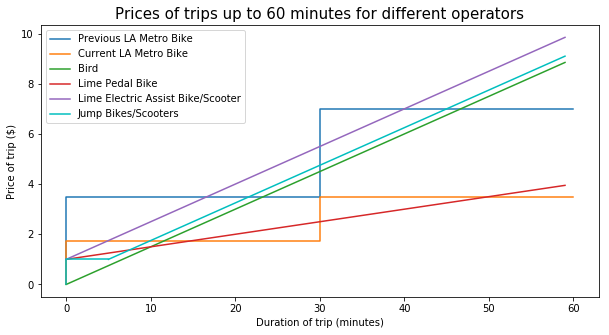

In [24]:
fig, axes = plt.subplots(figsize=(10,5))
x = np.array(range(0,60))
prev_la, = plt.step([0,30,60], [0,3.5,7], label = 'Previous LA Metro Bike')
cur_la, = plt.step([0,30,60], [0,1.75,3.5], label = 'Current LA Metro Bike')
bird, = plt.plot(x, 0.15 * x, label = 'Bird')
lime_ped, = plt.plot(x, 1 + 0.05 * x, label = 'Lime Pedal Bike')
lime_scoot, = plt.plot(x, 1 + 0.15 * x, label = 'Lime Electric Assist Bike/Scooter')
jump1, = plt.step([0,5],[0,1],label = 'Jump Bikes/Scooters',color = 'c')
jump2, = plt.plot(np.array(range(5,60)), 0.15 * np.array(range(5,60)) + 0.25, color = 'c')
plt.title('Prices of trips up to 60 minutes for different operators', size=15)
plt.xlabel('Duration of trip (minutes)')
plt.ylabel('Price of trip ($)')
plt.legend()
plt.show()

It can be observed from the above plot that the current pricing model enacted by LA Metro is one of cheapest being $3.5 for an hour-long bike ride. For rides shorter than 15 minutes and between 30 to 50 minutes, Lime pedal bike is the cheapest. These values are used to set up upper bound on prices to be used in the optimization model. 

1.	The variable rate per minute without a pass is set under the average of the two most common prices of 0.05 and 0.15:

Variable rate per minute without pass <= $0.10

2.	The variable rate per minute with a plan is set under the average of the LA Metro’s current 0.06 and Jump’s $0.07:

Variable rate per minute with pass <= $0.065

3.	The variable rate per 30 minutes is set under the nearest competitor(Lime pedal):

Variable rate per 30 minutes <= $2.5


### Quadratic Optimization
Judging from the above linear optimization results, we keep the daily and monthly plans in our pricing scheme. We will also replace the previous annual (Flex) plan with the new plan costing $150 per annum.

The total revenue would be optimized for two main factors: price and number of rides.  If a simple linear optimization with an upper bound for price was run, it would intuitively move towards the upper bound for optimization so a demand curve that would vary total rides taken along with the prices charged for each hour block is taken into consideration. 

##### Demand curves by customer segments
Demand is broken down by customer segments?

Grouped tables are created across 2018 Q2 and 2018 Q3.

In [25]:
#new_data = pd.read_csv('../data/external/2018Q3.csv')
#old_data = pd.read_csv('../data/external/2018Q2.csv')
df1 = pd.read_csv('q1_2018.csv')
df2 = pd.read_csv('q2_2018.csv')
df3 = pd.read_csv('q3_2018.csv')
df4 = pd.read_csv('q4_2018.csv')

old_data = pd.concat([df1,df2],sort=True)
new_data = pd.concat([df3,df4],sort=True)
#Setting annual pass = flex as both of them are the same
new_data['passholder_type'].loc[new_data['passholder_type'] == "Annual Pass"] = "Flex Pass"

#### Demand curve estimation

2018 Q1 and Q2 would be considered for data before the price change and Q3 and Q4 would be considered for data after the price change since 2018 Q2 was the last datapoint before the price change and 2018 Q3 was the first after. We set y as price for every 30 minute ride and x as the total number of rides in that quarter.

In [26]:
x1 = old_data.shape[0]
x2 = new_data.shape[0]
y1 = 3.5
y2 = 1.75

slope = (y2-y1)/(x2-x1)
intercept = y2 - x2 * slope

def print_func(slope, intercept):
    print('The linear function from two data points is: y =',slope,'x +',intercept)
    print('Where y = price for half hour block\n      x = rides in fiscal quarter')

print_func(slope, intercept)
print(x1,x2)

The linear function from two data points is: y = -6.627281678406423e-05 x + 12.960046959024465
Where y = price for half hour block
      x = rides in fiscal quarter
142744 169150


In [27]:
#Creating 30 mins time block that walk-up users have to pay for
old_data['time_block_count'] = old_data['duration'].apply(lambda duration: math.ceil(duration/30))

#Creating another feature for 30 minute blocks for passholders that excludes first 30 mintues
old_data['time_block_count_post_free'] = old_data['duration'].apply(lambda duration: math.ceil(duration/30))-1

#Creating 30 mins time block that walk-up users have to pay for
new_data['time_block_count'] = new_data['duration'].apply(lambda duration: math.ceil(duration/30))

#Creating another feature for 30 minute blocks for passholders that excludes first 30 mintues
new_data['time_block_count_post_free'] = new_data['duration'].apply(lambda duration: math.ceil(duration/30))-1

### Comparison of the number of rides in each category between the old and new pricing model

In [37]:
new_riders = new_data.groupby('passholder_type').agg({
    'trip_id' : 'count',
    'duration' : 'sum'
}).rename(columns = {
    'trip_id':'total_trips',
    'duration':'total_minutes'
})


old_riders= old_data.groupby('passholder_type').agg({
    'trip_id' : 'count',
    'duration' : 'sum'
}).rename(columns = {
    'trip_id':'total_trips',
    'duration':'total_minutes'
})

old_riders['percent_total_trips'] = old_riders['total_trips']/sum(old_riders['total_trips'])

new_riders['percent_total_trips'] = new_riders['total_trips']/sum(new_riders['total_trips'])

print("Number of trips in the old pricing model for Q1 & Q2 in 2018")
display(old_riders)
print("Number of trips in the old pricing model for Q3 & Q4 in 2018")
display(new_riders)

Number of trips in the old pricing model for Q1 & Q2 in 2018


,total_trips,total_minutes,percent_total_trips
passholder_type,,,
Flex Pass,4599,94530,0.032219
Monthly Pass,80644,1326849,0.564955
One Day Pass,10238,716319,0.071723
Walk-up,47263,3169181,0.331103


Number of trips in the old pricing model for Q3 & Q4 in 2018


,total_trips,total_minutes,percent_total_trips
passholder_type,,,
Flex Pass,4259,70745,0.025179
Monthly Pass,81159,1488569,0.479805
One Day Pass,7139,511330,0.042205
Walk-up,76593,5461078,0.452811


This steep fall in the number of daily  passes sold indicate that the customers are not willing to invest in the daily pass under the new pricing model as the price of the walk-up has been reduced from $3.5 for 30 minutes to $1.75 for 30 minutes. 

Furthermore, it can be observed that the number of walk-up has also increased from 47623 to 76593. The increase in number of walk-up and the decrease in the number of passes sold suggests us that the bike riders prefer to use the walk-up option under the new pricing model. 


In [29]:
slope_walk_up = (1.75-3.5) / (new_riders['total_trips']['Walk-up']-old_riders['total_trips']['Walk-up'])
slope_daily = (1.75-3.5) / (new_riders['total_trips']['One Day Pass']-old_riders['total_trips']['One Day Pass'])
slope_monthly = (1.75-3.5) / (new_riders['total_trips']['Monthly Pass']-old_riders['total_trips']['Monthly Pass'])
slope_annual = (1.75-3.5) / (new_riders['total_trips']['Flex Pass']-old_riders['total_trips']['Flex Pass'])

intercept_walk_up = 1.75 - new_riders['total_trips']['Walk-up'] * slope_walk_up
intercept_daily = 1.75 - new_riders['total_trips']['One Day Pass'] * slope_daily
intercept_monthly = 1.75 - new_riders['total_trips']['Monthly Pass'] * slope_monthly
intercept_annual = 1.75 - new_riders['total_trips']['Flex Pass'] * slope_annual

print('Walk up demand function estimate')
print_func(slope_walk_up, intercept_walk_up)   
print('\n')
print('Daily pass demand function estimate')
print_func(slope_daily, intercept_daily)   
print('\n')
print('Monthly pass demand function estimate')
print_func(slope_monthly, intercept_monthly)
print('\n')
print('Annual(Flex) pass demand function estimate')
print_func(slope_annual, intercept_annual)

Walk up demand function estimate
The linear function from two data points is: y = -5.966587112171838e-05 x + 6.3199880668257755
Where y = price for half hour block
      x = rides in fiscal quarter


Daily pass demand function estimate
The linear function from two data points is: y = 0.0005646982897708938 x + -2.2813810906744107
Where y = price for half hour block
      x = rides in fiscal quarter


Monthly pass demand function estimate
The linear function from two data points is: y = -0.0033980582524271844 x + 277.53300970873784
Where y = price for half hour block
      x = rides in fiscal quarter


Annual(Flex) pass demand function estimate
The linear function from two data points is: y = 0.005147058823529412 x + -20.171323529411765
Where y = price for half hour block
      x = rides in fiscal quarter


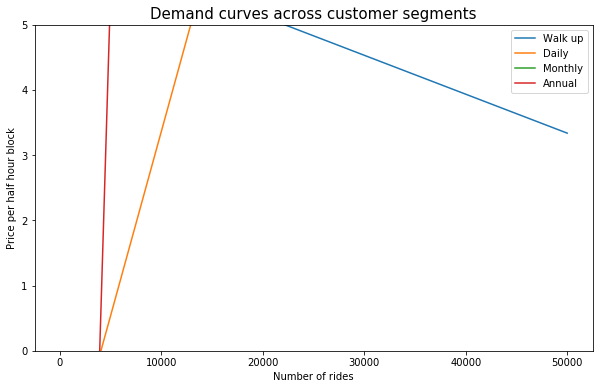

In [30]:
def walk_up_demand(x):
    return slope_walk_up * x + intercept_walk_up

def daily_demand(x):
    return slope_daily * x + intercept_daily

def monthly_demand(x):
    return slope_monthly * x + intercept_monthly

def annual_demand(x):
    return slope_annual * x + intercept_annual

q = np.linspace(0,50000)
fig, axes = plt.subplots(figsize=(10,6))
plt.plot(q, walk_up_demand(q), label = 'Walk up')
plt.plot(q, daily_demand(q), label = 'Daily')
plt.plot(q, monthly_demand(q), label = 'Monthly')
plt.plot(q, annual_demand(q), label = 'Annual')
plt.title('Demand curves across customer segments', size=15)
plt.xlabel('Number of rides')
plt.ylabel('Price per half hour block')
plt.ylim(0,5)
plt.legend();

It can be noted from the above figure that the typical demand curve with a negative slope is observed only for the walk-up riders. This is because of the drastic rate cut in rates from 3.5 to $1.75 which motivated customers to start using walk-up option instead of purchasing the passes and the prices for passes did not fall proportionately for half hourly rates so it became more economical to forgo the passes. 

### Optimization with Scipy Optimize

In [31]:
# Constants

daily_pass = old_agg_pass_groups['new_pass_prices']['One Day Pass']
monthly_pass = old_agg_pass_groups['new_pass_prices']['Monthly Pass']
annual_pass = old_agg_pass_groups['new_pass_prices']['Flex Pass']

walk_up_share = old_agg_pass_groups['percent_total_trips']['Walk-up']
daily_share = old_agg_pass_groups['percent_total_trips']['One Day Pass']
monthly_share = old_agg_pass_groups['percent_total_trips']['Monthly Pass']
annual_share = old_agg_pass_groups['percent_total_trips']['Flex Pass']

walk_up_charged_blocks = old_agg_pass_groups['average_charged_blocks_per_ride']['Walk-up']
daily_charged_blocks = old_agg_pass_groups['average_charged_blocks_per_ride']['One Day Pass']
monthly_charged_blocks = old_agg_pass_groups['average_charged_blocks_per_ride']['Monthly Pass']
annual_charged_blocks = old_agg_pass_groups['average_charged_blocks_per_ride']['Flex Pass']

An objective function of total revenue based on the price and the number of rides is defined. 

As a quadratic optimization problem is naturally a minimization problem, total revenue is returned as  ‘-total_revenue’ with a negative sign to obtain the maximum.

In [32]:
from scipy.optimize import minimize

# Base quadratic with demand curve.

def objective(x):
    rate = x[0]
    riders = x[1]
    
    walk_up_rev = riders * walk_up_share * walk_up_charged_blocks * rate
    day_rev = riders * daily_share * daily_charged_blocks * rate
    month_rev = riders * monthly_share * monthly_charged_blocks * rate
    annual_rev = riders * annual_share * annual_charged_blocks * rate
    
    day_pass_rev = riders * daily_share * daily_pass
    month_pass_rev = riders * monthly_share * monthly_pass
    annual_pass_rev = riders * annual_share * annual_pass
    
    total_revenue = walk_up_rev + day_rev + month_rev + annual_rev + day_pass_rev + month_pass_rev + annual_pass_rev
    return -total_revenue

#Constraints are similarly defined as individual functions with the same indexing of individual variables.
def demand_constraint(x):
    rate = x[0]
    riders = x[1]
    return rate - slope * riders - intercept

#A dictionary created to label the type of constraint and list all the individual constraints.
cons = {'type':'eq', 'fun':demand_constraint}

#b1 represent by upper and lower bound for the rate charged
b1 = (1.5, 2.5)
#b2 represents the range of the total number of rides
b2 = (50000, 190000)

bnds = (b1,b2)

#initial guess of the variables which is the current pricing and total rides values to use as our initial guess.
x0 = np.array([1.75, 142744])

sol = minimize(objective, x0, method='SLSQP', constraints=cons, bounds=bnds)

print(sol)
print(-round(sol['fun']))

     fun: -3169692.0725216856
     jac: array([-3.7314625e+04, -1.8375000e+01])
 message: 'Optimization terminated successfully.'
    nfev: 48
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([1.50000001e+00, 1.72922286e+05])
3169692


From this optimization, it seems that revenue is optimized when price is set at $1.6 for every half hour. This would increase total rides to 172,922.

The total revenue would increase to $3,169,692.

It seems that the negative demand slope meant that reducing prices to the lower bound was the most effect revenue maximizing strategy.

What if bounds on the variables are adjusted? What if minimum price was allowed to drop further below $1? What if competition was fiercer than expected and maximum ride growth was limited to below 150,000 rides?

The following bounds are to a sensitivity analysis

In [33]:
price_range_1 = (0.75, 2.5)
price_range_2 = (1.25, 2.5)
price_range_3 = (1.5, 2.5)
price_range_4 = (1.75, 2.5)

rider_range_1 = (50000, 180000)
rider_range_2 = (50000, 200000)
rider_range_3 = (50000, 220000)
rider_range_4 = (50000, 240000)

bounds = [((price_range_1, rider_range_1)) , ((price_range_1, rider_range_2)) , ((price_range_1, rider_range_3))
          , ((price_range_1, rider_range_4)) , ((price_range_2, rider_range_1)) , ((price_range_2, rider_range_2))
          , ((price_range_2, rider_range_3)) , ((price_range_2, rider_range_4)) , ((price_range_3, rider_range_1))
          , ((price_range_3, rider_range_2)) , ((price_range_3, rider_range_3)) , ((price_range_3, rider_range_4))
          , ((price_range_4, rider_range_1)) , ((price_range_4, rider_range_2)) , ((price_range_4, rider_range_3))
          , ((price_range_4, rider_range_4))
          ]

sensitivity_results = [minimize(objective, x0, method='SLSQP', constraints=cons, bounds=bnds) for bnds in bounds]
sensitivity_total_rev = [-round(sol['fun']) for sol in sensitivity_results]
sensitivity_rate = [round(sol['x'][0]) for sol in sensitivity_results]
sensitivity_riders = [round(sol['x'][1]) for sol in sensitivity_results]
price_ranges = [pair[0] for pair in bounds]
rider_ranges = [pair[1] for pair in bounds]

sensitivity_sorted = sorted(list(zip(sensitivity_total_rev, sensitivity_rate, sensitivity_riders, price_ranges, 
                                     rider_ranges)), reverse = True)

print('Total rev | Rate | Total riders | Rate range | Rider range')
for test_i in range(len(sensitivity_sorted)):
    print(sensitivity_sorted[test_i][0], '   ',sensitivity_sorted[test_i][1], '  ',
          sensitivity_sorted[test_i][2], 
          '     ',sensitivity_sorted[test_i][3], '   ', sensitivity_sorted[test_i][4])

Total rev | Rate | Total riders | Rate range | Rider range
3347314     1.0    184239.0       (0.75, 2.5)     (50000, 240000)
3347314     1.0    184239.0       (0.75, 2.5)     (50000, 220000)
3347314     1.0    184239.0       (0.75, 2.5)     (50000, 200000)
3281208     1.0    180000.0       (0.75, 2.5)     (50000, 180000)
3229306     1.0    176695.0       (1.25, 2.5)     (50000, 240000)
3229306     1.0    176695.0       (1.25, 2.5)     (50000, 220000)
3229306     1.0    176695.0       (1.25, 2.5)     (50000, 200000)
3229306     1.0    176695.0       (1.25, 2.5)     (50000, 180000)
3169692     2.0    172922.0       (1.5, 2.5)     (50000, 240000)
3169692     2.0    172922.0       (1.5, 2.5)     (50000, 220000)
3169692     2.0    172922.0       (1.5, 2.5)     (50000, 200000)
3169692     2.0    172922.0       (1.5, 2.5)     (50000, 180000)
3109671     2.0    169150.0       (1.75, 2.5)     (50000, 240000)
3109671     2.0    169150.0       (1.75, 2.5)     (50000, 220000)
3109671     2.0    16

With the given demand curve, it seems that adopting the lowest possible price of Dollar 1 results in a maximum of 184,239 rides. It also results in the highest possible revenue of Dollar 3,347,77314.

Across the board, it seems that as long as we are able to attract more than 180,000 rides, the strategy should be to reduce prices. Given what we’re seeing here, perhaps the drastic drop of 50% from the previous pricing scheme was justified.